In [1]:
import numpy as np
import pandas as pd
import csv
import ast
import collections
import matplotlib.pyplot as plt
import random
import tempfile
import urllib.request
import os

DATA_DIR_PATH = '../data/czi-software-mentions/'
RAW_FILE_PATH = f'{DATA_DIR_PATH}/raw.tar.gz'
LINKED_FILE_PATH = f'{DATA_DIR_PATH}/linked.tar.gz'
RAW_TAR_URL = "https://datadryad.org/stash/downloads/file_stream/1822384"
LINKED_TAR_URL = "https://datadryad.org/stash/downloads/file_stream/1822388"
# DISAMBIGUATED_TAR_URL = "https://datadryad.org/stash/downloads/file_stream/1822387"

def remove_empty_spaces(dic):
    """ Function removing an empty space at the first position of a string. 
    """
    for i in dic:
        if dic[i][:1] == " ":
            dic[i] = dic[i].strip()
    return dic

In [2]:
# Prepapre data directory and check if files exist to avoid duplicate large downloads
raw_exists = False
linked_exists = False
try:
    os.makedirs(DATA_DIR_PATH)
except FileExistsError:
    raw_exists = os.path.isfile(RAW_FILE_PATH)
    linked_exists = os.path.isfile(LINKED_FILE_PATH)
    tsvs_exist = (
        os.path.isfile(f'{DATA_DIR_PATH}/raw/raw/comm_raw.tsv') and
        os.path.isfile(f'{DATA_DIR_PATH}/raw/raw/non_comm_raw.tsv') and
        os.path.isfile(f'{DATA_DIR_PATH}/raw/raw/publishers_collections_raw.tsv')
    )

In [3]:
# Prepare a progressbar to track download progress
import progressbar

class DownloadProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar=progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

In [4]:
# Retrieve data from CZI dataset into data directory
if not linked_exists:
    urllib.request.urlretrieve(LINKED_TAR_URL, LINKED_FILE_PATH, DownloadProgressBar())

In [5]:
if not raw_exists:
    urllib.request.urlretrieve(RAW_TAR_URL, RAW_FILE_PATH, DownloadProgressBar())

In [6]:
# Extract dataset tarballs
if not tsvs_exist:
    import tarfile

    with tarfile.open(RAW_FILE_PATH) as raw_tar:
        raw_tar.extractall(f'{DATA_DIR_PATH}/raw/')
    with tarfile.open(LINKED_FILE_PATH) as linked_tar:
        linked_tar.extractall(f'{DATA_DIR_PATH}/linked/')

In [7]:
# gunzip needed files
if not tsvs_exist:
    import gzip
    import shutil
    for gzip_file in [
        f'{DATA_DIR_PATH}/raw/raw/comm_raw.tsv.gz',
        f'{DATA_DIR_PATH}/raw/raw/non_comm_raw.tsv.gz',
        f'{DATA_DIR_PATH}/raw/raw/publishers_collections_raw.tsv.gz',
    ]:
        with gzip.open(gzip_file, 'rb') as f_in:
            with open(gzip_file[:-3], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

In [8]:
#Take a look at the data and basic cleaning
# Use dask, as we're dealing with potentially larger-than-memory data (e.g. the raw publishers mentions dataset has 10+GB)
import dask.dataframe as dd

# Read TSV into a single dataframe, brute-force mapping all values to strings
df_czi = dd.concat([
    dd.read_csv(f'{DATA_DIR_PATH}/raw/raw/comm_raw_preview.tsv', sep='\t', converters={i: str for i in range(14770211)}),
    dd.read_csv(f'{DATA_DIR_PATH}/raw/raw/non_comm_raw_preview.tsv', sep='\t', converters={i: str for i in range(4546609)}),
    dd.read_csv(f'{DATA_DIR_PATH}/raw/raw/publishers_collections_raw_preview.tsv', sep='\t', converters={i: str for i in range(42868907)})
],
ignore_index=True)


600


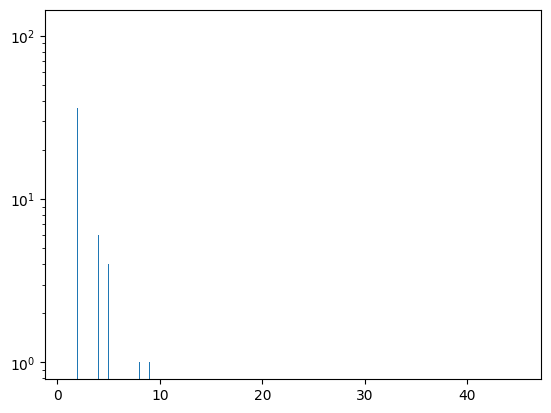

In [11]:
software = df_czi.software
software = software.explode()
software = software.str.replace('\'', '')
software.value_counts(dropna=False)

software_dict = software.compute()
# software_dict = remove_empty_spaces(software_dict)
software_series = pd.Series(software_dict)

#This is what our data looks like on a log scale
#Approx 100k software
#Approx 600k mentions
#Note around half the data has 1 citation, around 8% >10 citations, less than 1.5% have >50
plt.hist(software_series.value_counts(),bins=1000)
plt.yscale('log', nonpositive='clip')
print(len(software_dict))

In [12]:
# Save the whole humungous dataframe to a single file
df_czi.to_csv(f"{DATA_DIR_PATH}/czi.csv", index=False, encoding='utf-8-sig', single_file=True)

['/home/stephan/src/habeas-corpus/data/czi-software-mentions/czi.csv']

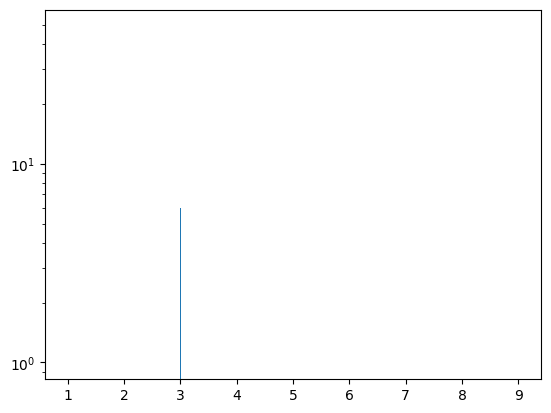

In [13]:
# Take random sample of data, and save as CSV

SAMPLE_COUNT = 100

i = 0
with open(f"{DATA_DIR_PATH}/czi.csv", 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    row_count = sum(1 for row in csv_reader)
    rand_ints = random.sample(range(1, row_count), SAMPLE_COUNT)
    with open(f"{DATA_DIR_PATH}/czi_output_random_100.csv", 'w') as output:
        output_writer = csv.writer(output, delimiter=',')
        csv_file.seek(0)
        for row in csv_reader:
            if i == 0 or i in rand_ints:
                output_writer.writerow(row)
            i += 1
            
CZI_CSV = pd.read_csv(f"{DATA_DIR_PATH}/czi_output_random_100.csv")
software = CZI_CSV.software
software = software.explode(ignore_index = True)
software = software.str.replace('\'', '')
software.value_counts(dropna=False)
software_dict = software.to_dict()
software_dict = remove_empty_spaces(software_dict)
software_series_sample = pd.Series(software_dict)
plt.hist(software_series_sample.value_counts(),bins=1000)
plt.yscale('log', nonpositive='clip')

In [14]:
#Population is non-normal so to test variances use Levene's test 
#https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm

from scipy.stats import levene
stat,p=levene(software_series.value_counts(), software_series_sample.value_counts())
print(p)
#Actual values of variances
[np.var(x, ddof=1) for x in [software_series.value_counts(), software_series_sample.value_counts()]]

#Gives small p-values, populations don't have equal variances (unsurprisingly...)

0.04203601673167068


[34.045390759930925, 2.4398361495135705]

In [15]:
# Can create stratified sample, here the y data are bins to split the #citations. Visually it's not so different from the fully random sample.
y=(np.linspace(0,0.999999999999,len(software.value_counts()))*1000).astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(software.value_counts(), y,stratify=y, test_size=1000)
plt.hist(X_test, bins=1000)
plt.yscale('log', nonpositive='clip')

ValueError: test_size=1000 should be either positive and smaller than the number of samples 63 or a float in the (0, 1) range

In [ ]:
# Does a sample look like the original (with actual tests as well as visually) if we exclude the top 10 cited?
# -> Sometimes

df_val_counts = pd.DataFrame(software.value_counts())
df_top10=df_val_counts.nlargest(10,'software')
df_without_top10=df_val_counts.nsmallest(len(df_val_counts)-10,'software')
sample_100=df_without_top10.sample(100)


from scipy.stats import levene
stat,p=levene(df_without_top10.software, sample_100.software)
print(p)
#Actual values of variances
print([np.var(x, ddof=1) for x in [df_without_top10.software, sample_100.software]])



#Save these as our sample:

sample_100.to_csv(f'{DATA_DIR_PATH}/100sample_without_top_10.csv',index=False)
df_top10.to_csv(f'{DATA_DIR_PATH}/top_10.csv',index=False)
